<a href="https://colab.research.google.com/github/Mahima7120/Open-Source-Project/blob/master/Plastic_detection_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/pedropro/TACO.git

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

dataset_path = '/content/PDAC/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


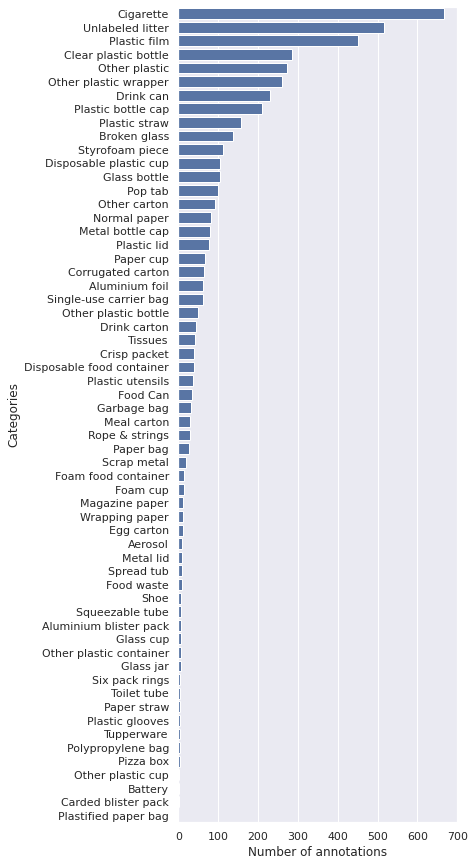

In [ ]:
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

f, ax = plt.subplots(figsize=(5,15))
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

fig = plot_1.get_figure()
fig.savefig("output.png")

Text(0.5, 1.0, 'Annotations per super category')

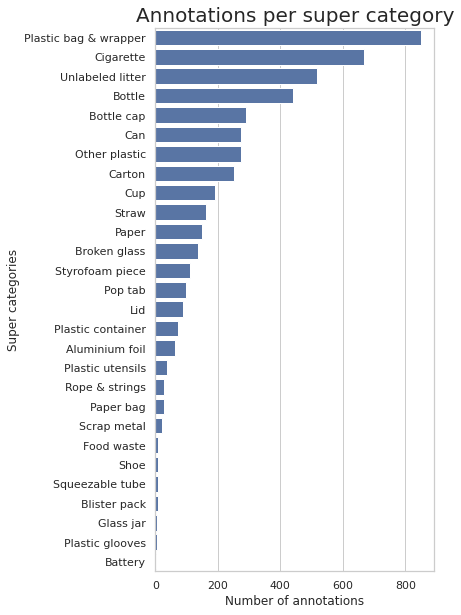

In [ ]:
cat_ids_2_supercat_ids = {}
for cat in categories:
    cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]

# Count annotations
super_cat_histogram = np.zeros(nr_super_cats,dtype=int)
for ann in anns:
    cat_id = ann['category_id']
    super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1

f, ax = plt.subplots(figsize=(5,10))
d ={'Super categories': super_cat_names, 'Number of annotations': super_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total", color="b")
plot_1.set_title('Annotations per super category',fontsize=20)

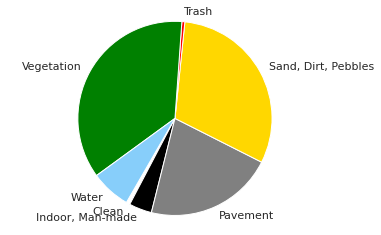

In [ ]:
scene_cats = dataset['scene_categories']
scene_name = []
for scene_cat in scene_cats:
    scene_name.append(scene_cat['name'])

nr_scenes = len(scene_cats)
scene_cat_histogram = np.zeros(nr_scenes,dtype=int)

for scene_ann in dataset['scene_annotations']:    
    scene_ann_ids = scene_ann['background_ids']
    for scene_ann_id in scene_ann_ids:
        if scene_ann_id<len(scene_cats):
            scene_cat_histogram[scene_ann_id]+=1

df = pd.DataFrame({'scene_cats': scene_cats, 'nr_annotations': scene_cat_histogram})
colors = ['white','black','gray', 'gold', 'red','green','lightskyblue']
plt.pie(scene_cat_histogram, labels=scene_name, colors = colors,
      shadow=False, startangle=-120)
 
plt.axis('equal')
plt.show()

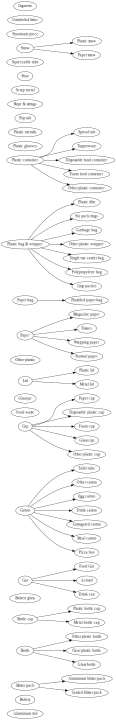

In [ ]:
from graphviz import Digraph
dot = Digraph('Dataset graph', filename='asd.gv')
dot.attr(rankdir='LR', size='8,10')

for cat_it in categories:
    dot.node(cat_it['name'])
    if cat_it['name']==cat_it['supercategory']:
        dot.node(cat_it['supercategory'])
    else:
        dot.edge(cat_it['supercategory'], cat_it['name'])
dot
#dot.view()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
batch_3/IMG_4967.JPG


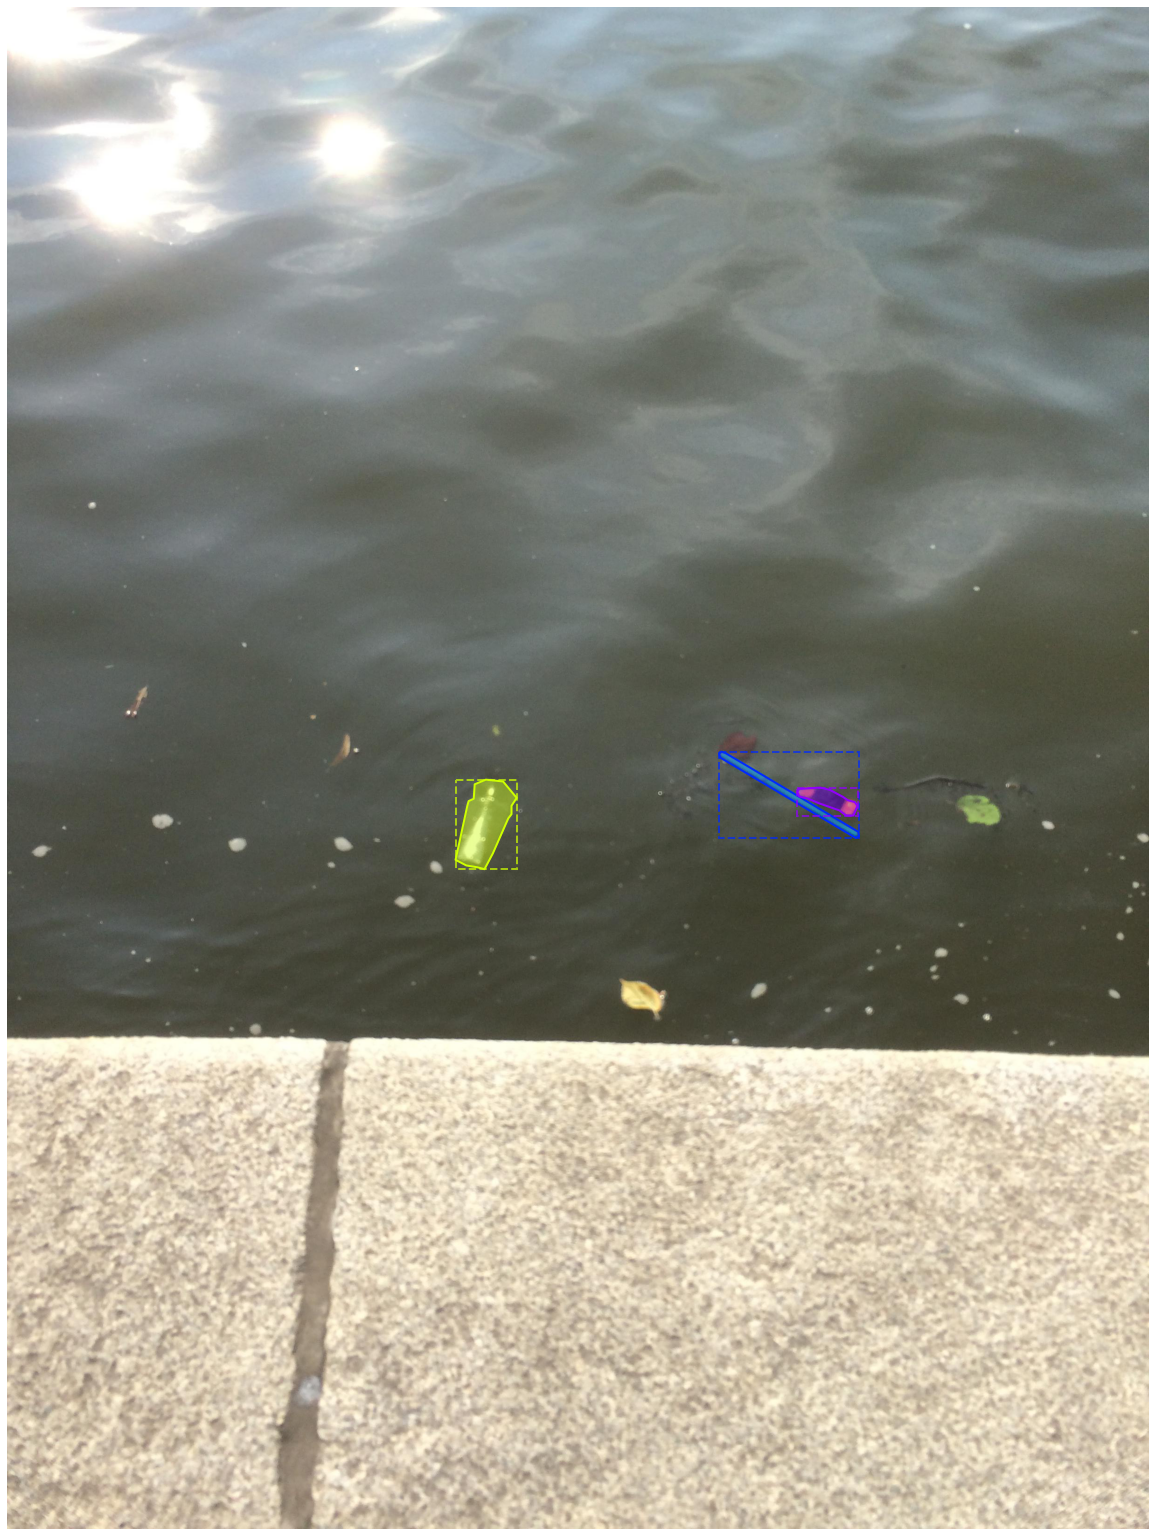

In [ ]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

image_filepath = 'batch_3/IMG_4967.JPG'
pylab.rcParams['figure.figsize'] = (28,28)

for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break
coco = COCO(anns_file_path)
img_id = -1
for img in imgs:
    if img['file_name'] == image_filepath:
        img_id = img['id']
        break
if img_id == -1:
    print('Incorrect file name')
else:

    print(image_filepath)
    I = Image.open(dataset_path + '/' + image_filepath)
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)

    # Show annotations
    for ann in anns_sel:
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        for seg in ann['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        [x, y, w, h] = ann['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Number of images found:  522
[{'id': 1228, 'width': 3264, 'height': 2448, 'file_name': 'batch_7/000066.JPG', 'license': None, 'flickr_url': 'https://farm66.staticflickr.com/65535/32912174767_c4f5cedc6b_o.png', 'coco_url': None, 'date_captured': None, 'flickr_640_url': 'https://farm66.staticflickr.com/65535/32912174767_65e144beb5_z.jpg'}, {'id': 1098, 'width': 3680, 'height': 2760, 'file_name': 'batch_6/000082.JPG', 'license': None, 'flickr_url': 'https://farm66.staticflickr.com/65535/46939963045_7211eea09b_o.png', 'coco_url': None, 'date_captured': None, 'flickr_640_url': 'https://farm66.staticflickr.com/65535/46939963045_00b9611ef6_z.jpg'}, {'id': 246, 'width': 3120, 'height': 4160, 'file_name': 'batch_11/000045.jpg', 'license': 'ODBL (c) OpenLitterMap & Contributors', 'flickr_url': 'https://olm-s3.s3.eu-west-1.amazonaws.com/2018/08/21/pc0xezfNnlYkVQZHIPS0PON4TW8cOynqoj1vl34k.jpeg', 'flickr_640_url': No

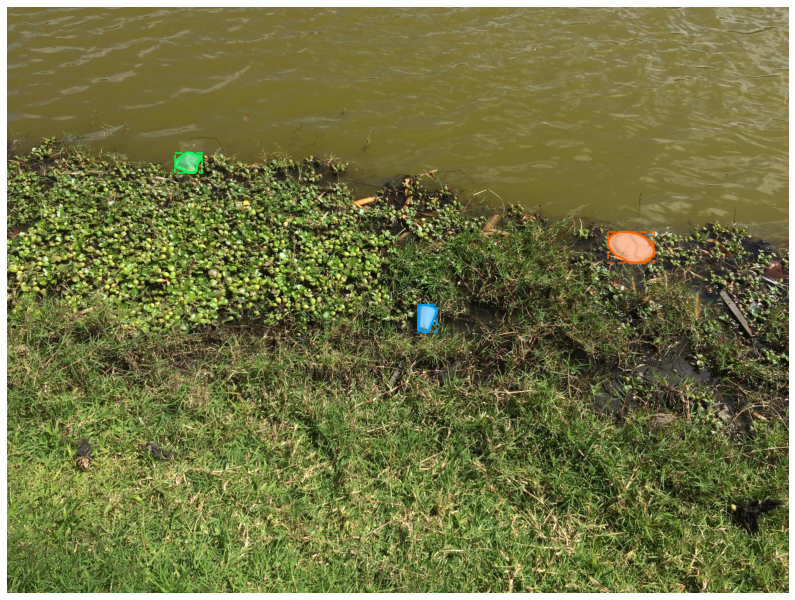

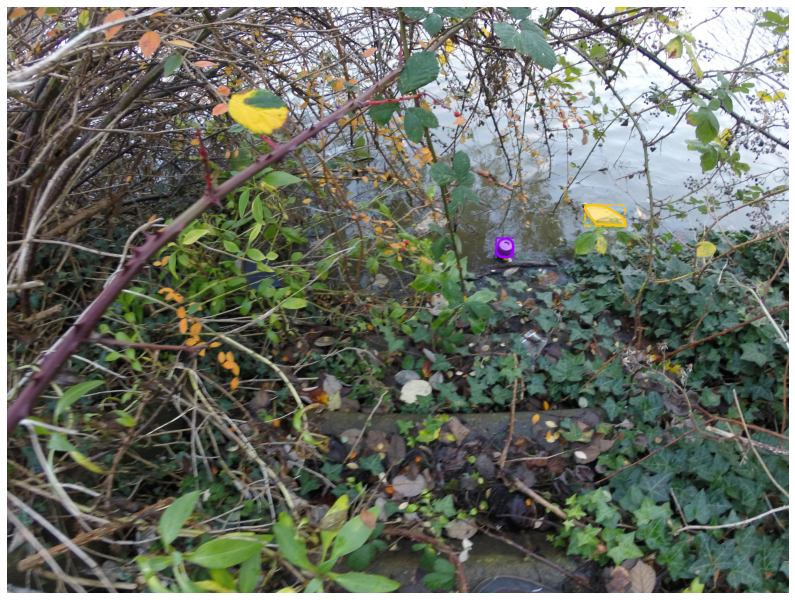

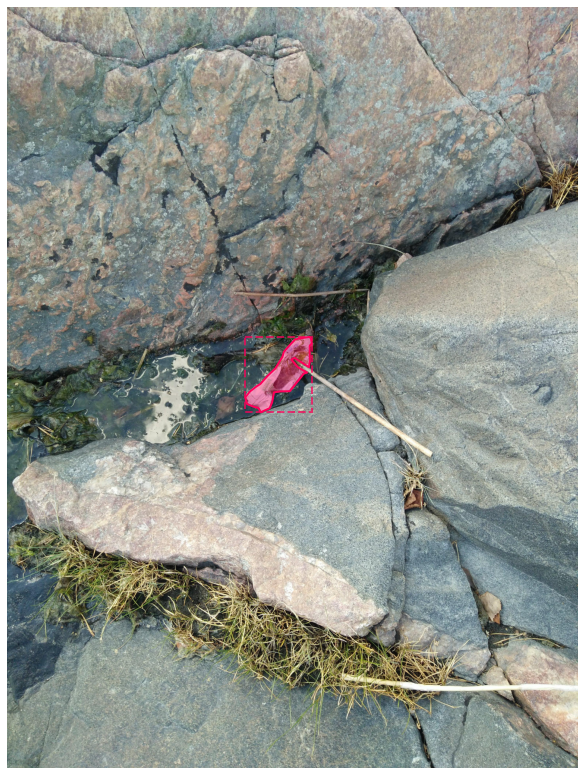

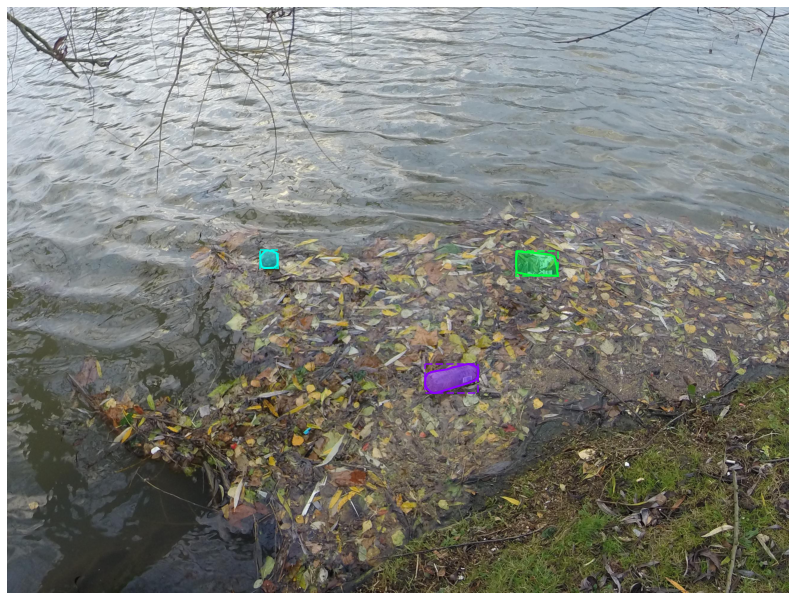

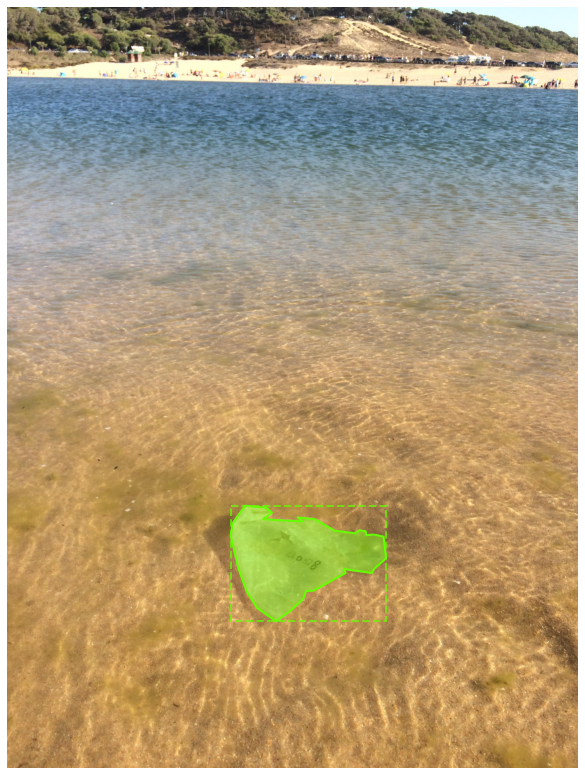

In [ ]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

nr_img_2_display = 5
category_name = 'Plastic bag & wrapper'
pylab.rcParams['figure.figsize'] = (14,14)

for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

coco = COCO(anns_file_path)
imgIds = []
catIds = coco.getCatIds(catNms=[category_name])
if catIds:
    imgIds = coco.getImgIds(catIds=catIds)
else:
    catIds = coco.getCatIds(supNms=[category_name])
    for catId in catIds:
        imgIds += (coco.getImgIds(catIds=catId))
    imgIds = list(set(imgIds))

nr_images_found = len(imgIds) 
print('Number of images found: ',nr_images_found)

# Select N random images
random.shuffle(imgIds)
imgIds=[1228,1098,246,1139,1418]
#imgIds=[781,1094,1420,1162,971,193]
imgs = coco.loadImgs(imgIds[0:min(nr_img_2_display,nr_images_found)])
print(imgs)
for img in imgs:
    image_path = dataset_path + '/' + img['file_name']
    # Load image
    I = Image.open(image_path)
    
    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)
  
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    #mask ids
    #annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    #when no category is needed
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)
    
    for ann in anns_sel:
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        for seg in ann['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        [x, y, w, h] = ann['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()
